# Explora aquí

Se recomienda utilizar este cuaderno con fines de exploración.

In [49]:
import os
from bs4 import BeautifulSoup
import requests
import time
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [50]:
# Download HTML 
url = 'https://ycharts.com/companies/TSLA/revenues'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

response = requests.get(url, headers=headers)

if response.status_code == 200:
    soup = BeautifulSoup(response.text, 'html.parser')

# Filtering HTML by tag name 
tesla_data = soup.find_all('td')

# Creating a clean list with dates and revenue values
tesla_qrev = [data.text.strip() for data in tesla_data]

# Separting the previous list and creating a df 
date, rev = tesla_qrev[::2], tesla_qrev[1::2]
tesla_rev = pd.DataFrame({
    'date': date,
    'rev': rev
})

In [51]:
# Dropping the last few rows, as those are not related to the quarterly revenue. 
tesla_rev.drop(tesla_rev.tail(14).index, inplace=True)
tesla_rev.tail()

,date,rev
45,"March 31, 2013",561.79M
46,"December 31, 2012",306.33M
47,"September 30, 2012",50.10M
48,"June 30, 2012",26.65M
49,"March 31, 2012",30.17M


In [52]:
# Converting the date into datatime
tesla_rev['date'] = pd.to_datetime(tesla_rev['date'])
tesla_rev.sort_values('date', inplace=True)

In [53]:
def converter(n):
    if n[-1] == 'M':
        return int(float(n[:-1]) * 1e6)
    if n[-1] == 'B':
        return int(float(n[:-1]) * 1e9)

tesla_rev['full_rev'] = tesla_rev['rev'].apply(converter)
tesla_rev['quarter'] = tesla_rev['date'].dt.to_period('Q').astype(str)
tesla_rev.head()


,date,rev,full_rev,quarter
49,2012-03-31,30.17M,30170000,2012Q1
48,2012-06-30,26.65M,26650000,2012Q2
47,2012-09-30,50.10M,50100000,2012Q3
46,2012-12-31,306.33M,306330000,2012Q4
45,2013-03-31,561.79M,561790000,2013Q1


In [54]:
# Creating a database with data from tesla_rev dataframe
conn = sqlite3.connect('tesla_database.db')
tesla_rev.to_sql('rev', conn, if_exists='replace', index=False)
conn.commit()

C:\Users\noehu\AppData\Local\Temp\ipykernel_21104\3144513473.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.0f} M'.format(x) for x in current_values])


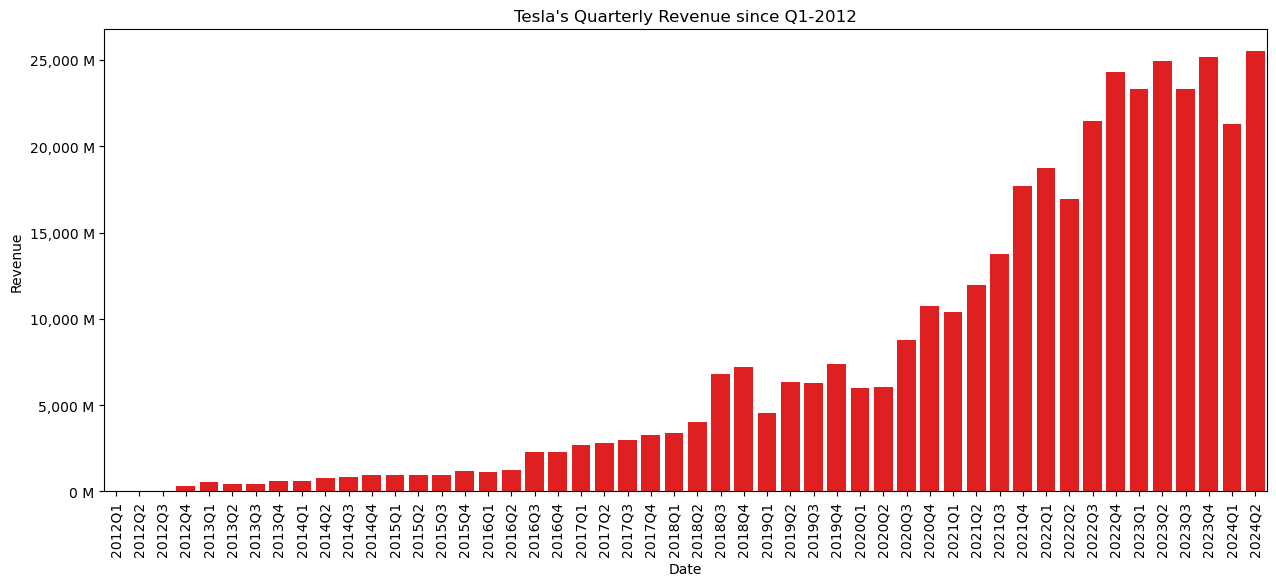

In [55]:
plt.figure(figsize=(15,6))
plt.title("Tesla's Quarterly Revenue since Q1-2012")
sns.barplot(x='quarter', y='full_rev', data=tesla_rev, color='red')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.ylabel('Revenue')
current_values = (plt.gca().get_yticks())/1000000
plt.gca().set_yticklabels(['{:,.0f} M'.format(x) for x in current_values])
plt.show()

C:\Users\noehu\AppData\Local\Temp\ipykernel_21104\3459834650.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='date', y='full_rev', data=yearly_rev, palette='flare')
C:\Users\noehu\AppData\Local\Temp\ipykernel_21104\3459834650.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.2f} B'.format(x) for x in current_values])


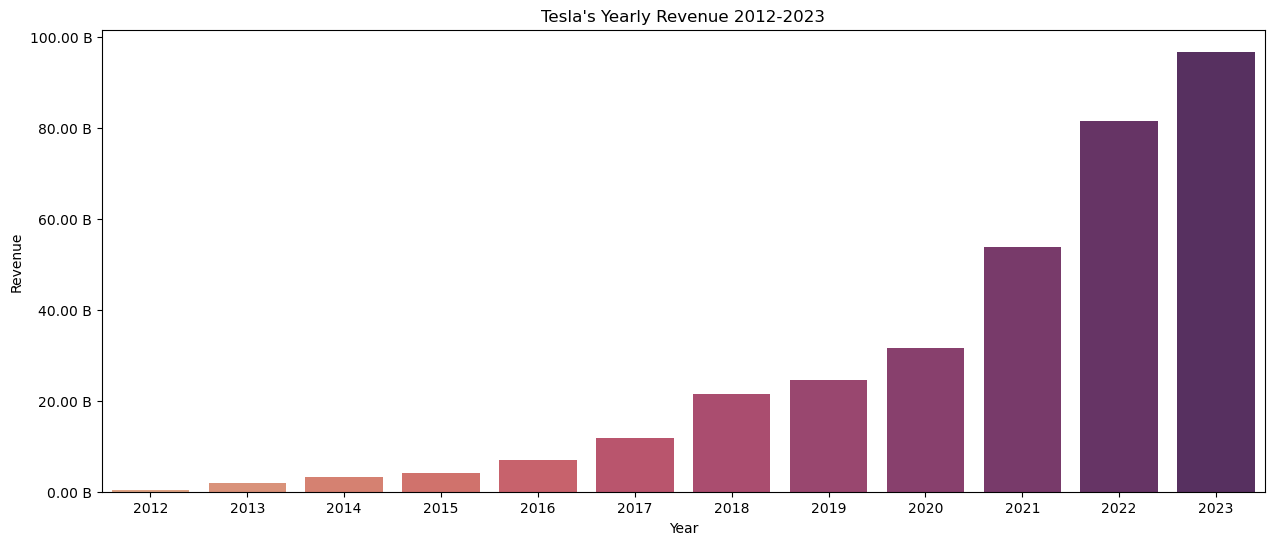

In [56]:
yearly_rev = tesla_rev.groupby(tesla_rev['date'].dt.year)['full_rev'].sum().reset_index()
yearly_rev.drop(index=12, axis=0, inplace=True)
plt.figure(figsize=(15,6))
plt.title("Tesla's Yearly Revenue 2012-2023")
sns.barplot(x='date', y='full_rev', data=yearly_rev, palette='flare')
plt.xlabel('Year')
plt.ylabel('Revenue')
current_values = (plt.gca().get_yticks())/1000000000
plt.gca().set_yticklabels(['{:,.2f} B'.format(x) for x in current_values])
plt.show()

In [57]:
# Creating a second table to compare Tesla's revenue vs other car manufacturers (benchmark)
bench = tesla_qrev[-28:-18]
comp, rev_q2 = bench[::2], bench[1::2]
benchmark = pd.DataFrame({
    'company': comp, 
    'revenue Q2': rev_q2
    })
benchmark.loc[len(benchmark.index)] = ['Tesla Inc', tesla_rev.loc[tesla_rev.index[49]]['rev']]
benchmark['full_rev'] = benchmark['revenue Q2'].apply(converter)
benchmark = benchmark.reset_index(drop=True).sort_values('full_rev')

benchmark.to_sql('benchmark', conn, if_exists='replace', index=False)
conn.commit()

C:\Users\noehu\AppData\Local\Temp\ipykernel_21104\4237819289.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:,.2f} B'.format(x) for x in current_values])


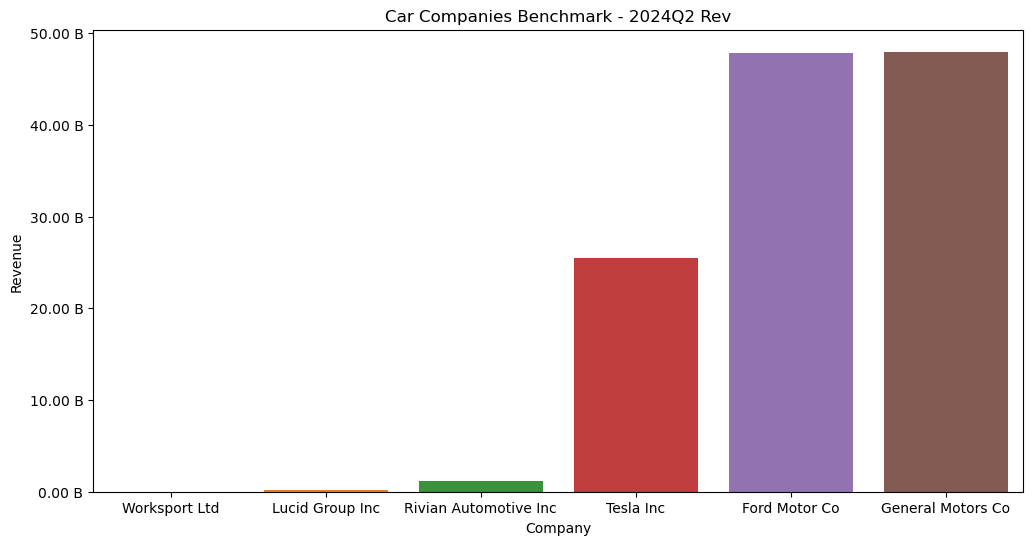

In [58]:
plt.figure(figsize=(12,6))
plt.title("Car Companies Benchmark - 2024Q2 Rev")
sns.barplot(data=benchmark, x='company', y='full_rev', hue='company')
plt.xlabel('Company')
plt.ylabel('Revenue')
current_values = (plt.gca().get_yticks())/1000000000
plt.gca().set_yticklabels(['{:,.2f} B'.format(x) for x in current_values])
plt.show()